In [1]:
import dgl
import torch
import numpy as np
from ogb.nodeproppred import DglNodePropPredDataset
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import tqdm
dataset = DglNodePropPredDataset('ogbn-arxiv',root='data/')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

graph, node_labels = dataset[0]
# Add reverse edges since ogbn-arxiv is unidirectional.
graph = dgl.add_reverse_edges(graph)
print(graph)
print(node_labels)

def get_node_feat(mode):
    
    if mode == 'xrt':
        return graph.ndata['xrt_features']
    elif mode == 'feat':
        return graph.ndata['feat']

Graph(num_nodes=169343, num_edges=2332486,
      ndata_schemes={'year': Scheme(shape=(1,), dtype=torch.int64), 'feat': Scheme(shape=(128,), dtype=torch.float32)}
      edata_schemes={})
tensor([[ 4],
        [ 5],
        [28],
        ...,
        [10],
        [ 4],
        [ 1]])


In [2]:
xrt_feature = np.load("/home/zhangxinjie/pecos/examples/giant-xrt/proc_data_xrt/ogbn-arxiv/X.all.xrt-emb.npy")
graph.ndata['xrt_features'] = torch.from_numpy(xrt_feature)
node_features = get_node_feat('feat')
node_labels = node_labels[:, 0]
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()
print('Number of classes:', num_classes)

idx_split = dataset.get_idx_split()
train_nids = idx_split['train']
valid_nids = idx_split['valid']
test_nids = idx_split['test']

Number of classes: 40


In [3]:
negative_sampler = dgl.dataloading.negative_sampler.Uniform(5)
sampler = dgl.dataloading.NeighborSampler([4, 4])
sampler = dgl.dataloading.as_edge_prediction_sampler(
    sampler, negative_sampler=negative_sampler)
train_dataloader = dgl.dataloading.DataLoader(
    # The following arguments are specific to DataLoader.
    dgl.node_subgraph(graph, train_nids),                                  # The graph
    torch.arange(dgl.node_subgraph(graph, train_nids).number_of_edges()),  # The edges to iterate over
    sampler,                                # The neighbor sampler
    device=device,                          # Put the MFGs on CPU or GPU
    # The following arguments are inherited from PyTorch DataLoader.
    batch_size=1024,    # Batch size
    shuffle=True,       # Whether to shuffle the nodes for every epoch
    drop_last=False,    # Whether to drop the last incomplete batch
    num_workers=0       # Number of sampler processes
)

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import SAGEConv


class Model(nn.Module):
    def __init__(self, in_feats, n_hidden):
        super().__init__()
        self.n_hidden = n_hidden
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, 'mean'))
        self.layers.append(SAGEConv(n_hidden, n_hidden, 'mean'))
        self.predictor = nn.Sequential(
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1))

    def predict(self, h_src, h_dst):
        return self.predictor(h_src * h_dst)

    def forward(self, pair_graph, neg_pair_graph, blocks, x):
        h = x
        for l, (layer, block) in enumerate(zip(self.layers, blocks)):
            h = layer(block, h)
            if l != len(self.layers) - 1:
                h = F.relu(h)
        pos_src, pos_dst = pair_graph.edges()
        neg_src, neg_dst = neg_pair_graph.edges()
        h_pos = self.predict(h[pos_src], h[pos_dst])
        h_neg = self.predict(h[neg_src], h[neg_dst])
        return h_pos, h_neg

    def inference(self, g, device, batch_size, num_workers, mode, buffer_device=None):
        feat = g.ndata[mode]
        sampler = dgl.dataloading.MultiLayerFullNeighborSampler(1, prefetch_node_feats=[mode])
        dataloader = dgl.dataloading.DataLoader(
                g, torch.arange(g.num_nodes()).to(g.device), sampler, device=device,
                batch_size=1024, shuffle=False, drop_last=False, num_workers=num_workers)
        if buffer_device is None:
            buffer_device = device

        for l, layer in enumerate(self.layers):
            y = torch.zeros(g.num_nodes(), self.n_hidden, device=buffer_device)
            index = []
            feat = feat.to(device)

            for input_nodes, output_nodes, blocks in tqdm.tqdm(dataloader):
                x = feat[input_nodes]
                h = layer(blocks[0], x)
                index.append(blocks[-1].dstdata[dgl.NID])
                if l != len(self.layers) - 1:
                    h = F.relu(h)
                y[output_nodes] = h.to(buffer_device)
            feat = y
        return y,torch.cat(index)  #get the embedding of the graph and index of the original nodes



In [6]:
model = Model(node_features.shape[1], 256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [8]:
def get_threshold(y_true,y_scores):
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    idx1 = np.where(tpr <= tnr)[0]
    t = thresholds[idx1[-1]]
    return t  # use the Youden Index as threshold

In [9]:
def train(mode):
    
    #best_model_path = 'model.pt'
    for epoch in range(1):
        global y_true
        global y_scores
        y_true, y_scores = [],[]
        model.train()
        with tqdm.tqdm(train_dataloader) as tq:
            for step, (input_nodes, pair_graph, neg_pair_graph, blocks) in enumerate(tq):
                x = blocks[0].srcdata[mode]
                pos_score, neg_score = model(pair_graph, neg_pair_graph, blocks, x)
                pos_label = torch.ones_like(pos_score)
                neg_label = torch.zeros_like(neg_score)
                score = torch.cat([pos_score, neg_score])
                labels = torch.cat([pos_label, neg_label])
                y_true.extend(labels.cpu().detach().numpy())
                y_scores.extend(score.cpu().detach().numpy())
                #loss = F.binary_cross_entropy_with_logits(score, labels)
                n_edges = pos_score.shape[0]
                loss = (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()
                opt.zero_grad()
                loss.backward()
                opt.step()
                tq.set_postfix({'loss': '%.03f' % loss.item()}, refresh=False)
                if (step+1) % 200 == 0:
                    with torch.no_grad():
                        auc = roc_auc_score(y_true, y_scores) 
                        print(f"auc:",auc)
                        if auc >=0.9:
                            break
                

In [10]:
def tpr_tnr_plot():         # to plot tpr_tnr curve 
    tpr, fpr, thresholds = roc_curve(y_true, y_scores)
    tnr = 1 - fpr
    plt.plot(thresholds, tpr, label='tpr')
    plt.plot(thresholds, tnr, label='tnr')
    plt.xlabel('Threshold')
    plt.title('TPR / TNR vs Threshold')
    plt.legend()

In [21]:
def evaluate(mode):
    from math import ceil
    model.eval()
    negative_sampler = dgl.dataloading.negative_sampler.Uniform(5)
    sampler = dgl.dataloading.NeighborSampler([4, 4])
    sampler = dgl.dataloading.as_edge_prediction_sampler(
        sampler, negative_sampler=negative_sampler)
    test_dataloader = dgl.dataloading.DataLoader(
        # The following arguments are specific to DataLoader.
        dgl.node_subgraph(graph, test_nids),                                  # The graph
        torch.arange(dgl.node_subgraph(graph, test_nids).number_of_edges()),  # The edges to iterate over
        sampler,                                # The neighbor sampler
        device=device,                          # Put the MFGs on CPU or GPU
        # The following arguments are inherited from PyTorch DataLoader.
        batch_size=1024,    # Batch size
        shuffle=True,       # Whether to shuffle the nodes for every epoch
        drop_last=False,    # Whether to drop the last incomplete batch
        num_workers=0       # Number of sampler processes
    )
    running_loss, total_loss = 0.0, 0.0
    num_correct, num_examples = 0, 0
    total_correct, total_examples = 0, 0
    test_y_true = []
    test_y_scores = []
    nums_batches = int(ceil(dgl.node_subgraph(graph, test_nids).number_of_edges()/1024))
    print('num_batches', nums_batches)
    for idx, (input_nodes, pos_graph, neg_graph, block) in enumerate(test_dataloader):
        y = block[0].srcdata[mode]
        pos_score, neg_score = model(pos_graph, neg_graph, block, y)
        pos_label = torch.ones_like(pos_score)
        neg_label = torch.zeros_like(neg_score)
        score = torch.cat([pos_score, neg_score])
        labels = torch.cat([pos_label, neg_label])
        test_y_true.extend(labels.cpu().detach().numpy())
        test_y_scores.extend(score.cpu().detach().numpy())
        #loss = F.binary_cross_entropy_with_logits(score, labels)
        n_edges = pos_score.shape[0]
        loss = (1 - pos_score + neg_score.view(n_edges, -1)).clamp(min=0).mean()
        
        total_loss += loss.item()
        running_loss += loss.item()
        predictions = (score >= threshold).long()
        num_correct += torch.sum(predictions == labels.long()).item()
        total_correct += torch.sum(predictions == labels.long()).item()
        num_examples += len(labels)
        total_examples += len(labels)
        if (idx + 1) % 30 == 0:
            running_loss /= 30
            accuracy = num_correct / num_examples
            print('    step:{}, loss {:.4f}, accuracy {:.4f}'.format(
                idx+1, running_loss, accuracy))
            if (torch.sum(labels.long() == 0).item() > 0) and (torch.sum(labels.long() == 1).item() > 0):
                auc = roc_auc_score(test_y_true, test_y_scores)
                print('    ROC-AUC score: {:.4f}'.format(auc))
            running_loss = 0.0
            num_correct, num_examples = 0, 0
    total_loss /= nums_batches
    total_accuracy = total_correct / total_examples
    print('Loss {:.4f}, accuracy {:.4f}'.format(total_loss, total_accuracy))

In [12]:
train('feat')

 27%|██▋       | 201/733 [00:29<10:34,  1.19s/it, loss=0.036]

auc: 0.8505730110120773


 55%|█████▍    | 400/733 [01:03<19:58,  3.60s/it, loss=0.037]

auc: 0.8962520208615066


 82%|████████▏ | 599/733 [01:26<00:15,  8.46it/s, loss=0.034]

auc: 0.9123031154693495


In [14]:
threshold = get_threshold(y_true, y_scores)

In [22]:
evaluate('feat')

num_batches 118
    step:30, loss 0.0287, accuracy 0.9279
    ROC-AUC score: 0.9848
    step:60, loss 0.0284, accuracy 0.9285
    ROC-AUC score: 0.9848
    step:90, loss 0.0286, accuracy 0.9277
    ROC-AUC score: 0.9848
Loss 0.0282, accuracy 0.9280


/home/zhangxinjie/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/home/zhangxinjie/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


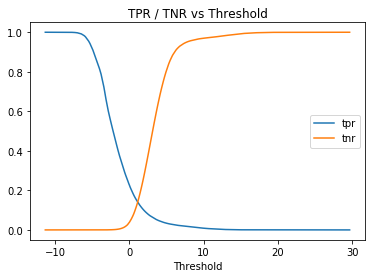

In [23]:
tpr_tnr_plot()

In [24]:
# train with features generated by XR-transformer
node_features = get_node_feat('xrt')
model = Model(node_features.shape[1], 256).to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

In [25]:
train('xrt_features')

 27%|██▋       | 201/733 [00:41<09:38,  1.09s/it, loss=0.037]

auc: 0.8725869005131721


 54%|█████▍    | 399/733 [01:16<01:01,  5.43it/s, loss=0.028]

auc: 0.915805193018913


In [26]:
threshold = get_threshold(y_true, y_scores)

In [27]:
evaluate('xrt_features')

num_batches 118
    step:30, loss 0.0575, accuracy 0.9108
    ROC-AUC score: 0.9646
    step:60, loss 0.0584, accuracy 0.9104
    ROC-AUC score: 0.9644
    step:90, loss 0.0583, accuracy 0.9096
    ROC-AUC score: 0.9645
Loss 0.0580, accuracy 0.9107
